<a href="https://colab.research.google.com/github/RokonUddin370/KNN-Classification-Assignment/blob/main/210120_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

sns.set(style='whitegrid')


In [9]:
url = "https://raw.githubusercontent.com/RokonUddin370/KNN-Classification-Assignment/main/data/diabetes.csv"
df = pd.read_csv(url)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
df = df.apply(pd.to_numeric, errors='coerce')
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed = df_imputed.dropna()
df_imputed = df_imputed[df_imputed['Outcome'].isin([0,1])]
X = df_imputed.drop("Outcome", axis=1)
y = df_imputed["Outcome"]

print("Class distribution after filtering valid classes:")
print(y.value_counts())
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Data preprocessing completed successfully.")

Class distribution after filtering valid classes:
Outcome
0.0    500
1.0    268
Name: count, dtype: int64
Data preprocessing completed successfully.


In [11]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)


Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


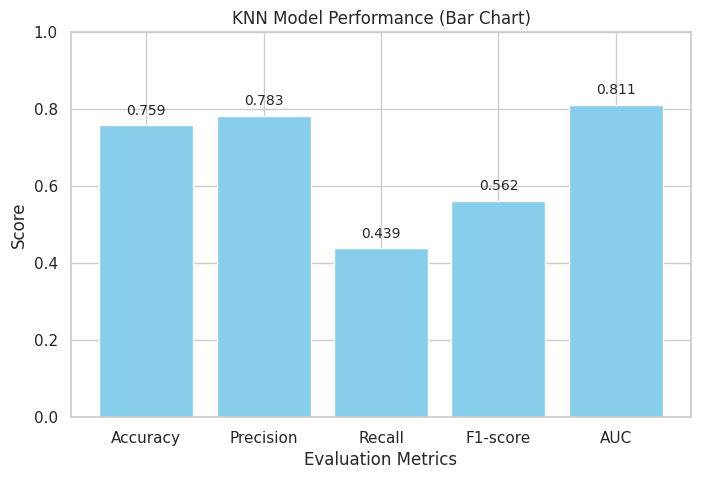

In [12]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
scores = [accuracy, precision, recall, f1, auc]

plt.figure(figsize=(8,5))
bars = plt.bar(metrics, scores, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("KNN Model Performance (Bar Chart)")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()


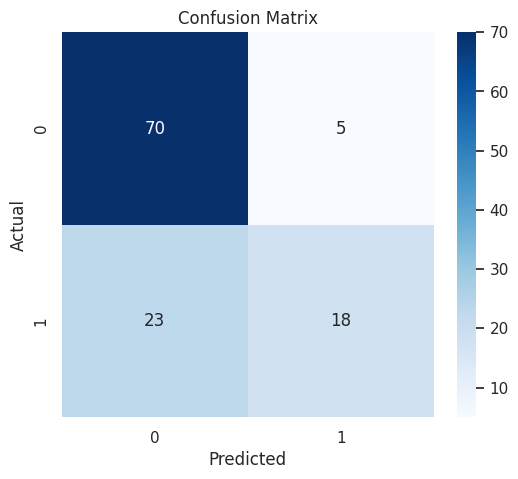

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


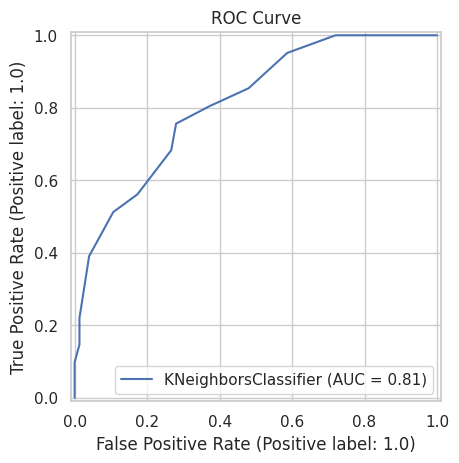

In [14]:
RocCurveDisplay.from_estimator(best_knn, X_test, y_test)
plt.title("ROC Curve")
plt.show()

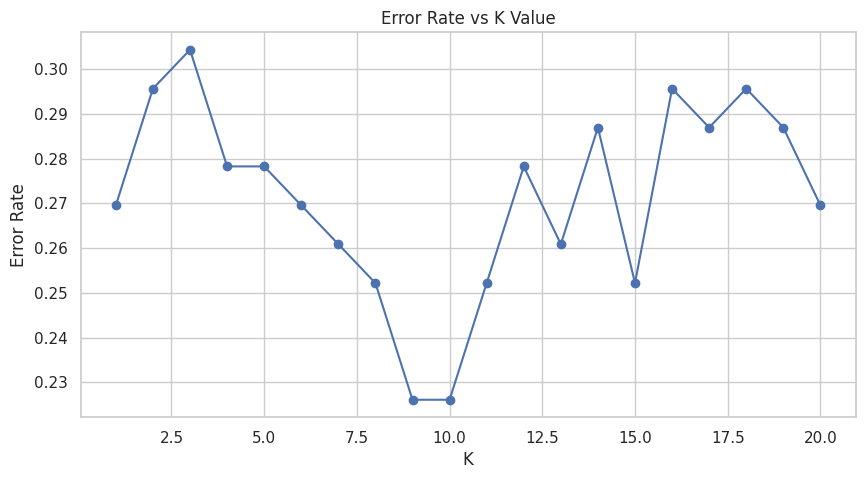

In [15]:
error_rate = []
for k in range(1, 21):
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    pred_k = knn_temp.predict(X_val)
    error_rate.append(1 - accuracy_score(y_val, pred_k))

plt.figure(figsize=(10,5))
plt.plot(range(1,21), error_rate, marker='o')
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

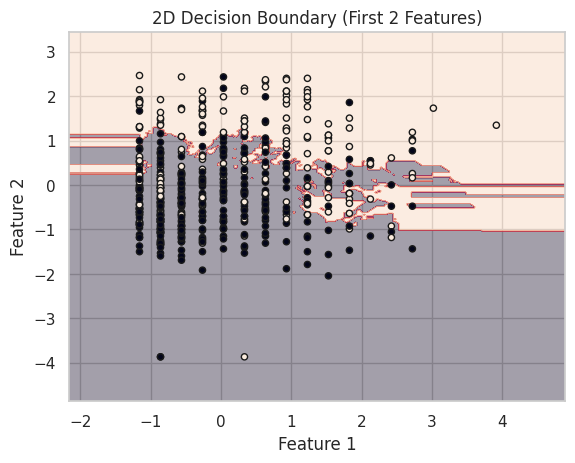

In [16]:
X_plot = X_train[:, :2]
y_plot = y_train
knn_2d = KNeighborsClassifier(**grid_search.best_params_)
knn_2d.fit(X_plot, y_plot)
h = 0.02
x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, s=20, edgecolor='k')
plt.title("2D Decision Boundary (First 2 Features)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()